In [155]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

from copy import deepcopy

import torch
import torch.nn as nn
import os
from src.nf.classic.utils import Densnet

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

env: CUDA_VISIBLE_DEVICES=0


device(type='cuda')

### Setup

In [2]:
! ls dumps_20200531

BSDS300  GAS  HEPMASS  MINIBOONE  POWER


In [3]:
data_name = 'GAS'
model_type = 'MAF'

num_layers = 5
num_iters = int(3 * 1e6)

model_name = f"{model_type}_{num_layers}"

model_save_dir = f'../models/{data_name}/{model_name}/'
os.makedirs(f'{model_save_dir}/checkpoints', exist_ok=True)
if model_type == 'SPLINE-AR':
    num_layers = 2

dumps_path = f'dumps_20200531/{data_name}/{model_type}_{num_layers}_ind1/checkpoints'
dump_path = os.path.join(
    dumps_path,
    max(os.listdir(dumps_path), key=lambda x: int(x.split('.')[0]))
)

In [4]:
dump_path

'dumps_20200531/GAS/MAF_5_ind1/checkpoints/450000.checkpoint'

### Data

In [5]:
from utils import data_utils

data_mapping = {'BSDS300': data_utils.BSDS300,
                'GAS': data_utils.GAS,
                'MINIBOONE': data_utils.MINIBOONE,
                'POWER': data_utils.POWER,
                'HEPMASS': data_utils.HEPMASS}
data = data_mapping[data_name]()
dim = data.n_dims

In [6]:
X_train_tensor = torch.from_numpy(data.trn.x).to(device)
X_test_tensor = torch.from_numpy(data.tst.x).to(device)

In [7]:
X_train_tensor.shape

torch.Size([852174, 8])

In [8]:
from torch.distributions import MultivariateNormal

prior = MultivariateNormal(torch.zeros(data.n_dims).to(device),
                           torch.eye(data.n_dims).to(device))


In [9]:
from src.mrartemev_nflib.flows import NormalizingFlowModel, InvertiblePermutation, Invertible1x1Conv, ActNorm, NSF_AR
from src.mrartemev_nflib.flows import MAF, AffineHalfFlow
from src.mrartemev_nflib.nn import ARMLP, MLP


flows = []
for _ in range(num_layers):
    if model_type == 'MAF':
        flows.append(MAF(dim=data.n_dims, base_network=ARMLP))
        flows.append(InvertiblePermutation(dim=data.n_dims))
    if model_type == 'SPLINE-AR':
        flows.append(ActNorm(dim=data.n_dims))
        flows.append(Invertible1x1Conv(dim=data.n_dims))
        flows.append(NSF_AR(dim=data.n_dims, K=8, B=3, hidden_features=32, depth=1, base_network=MLP))
    if model_type == 'GLOW':
        flows.append(ActNorm(dim=data.n_dims))
        flows.append(Invertible1x1Conv(dim=data.n_dims))
        flows.append(AffineHalfFlow(dim=data.n_dims, hidden_features=32, base_network=MLP))
        flows.append(InvertiblePermutation(dim=data.n_dims))
    if model_type == 'RealNVP':
        flows.append(AffineHalfFlow(dim=data.n_dims, base_network=MLP))
        flows.append(InvertiblePermutation(dim=data.n_dims))

lr = 0.0005
        
model = NormalizingFlowModel(prior, flows).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
checkpoint = torch.load(dump_path)
model.load_state_dict(checkpoint['model.state_dict()'])

<All keys matched successfully>

In [10]:
def to_device(model, device):
    model.to(device)
    model.prior = MultivariateNormal(torch.zeros(data.n_dims).to(device),
                                     torch.eye(data.n_dims).to(device))

to_device(model, device)

In [11]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from itertools import repeat

dloader = DataLoader(TensorDataset(X_train_tensor), batch_size=14000,
                     shuffle=True, drop_last=True)
test_dloader = DataLoader(TensorDataset(X_test_tensor), batch_size=2**8,
                          shuffle=True, drop_last=True)

def repeater(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data

dloader = repeater(dloader)

### Model eval

In [12]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from src.nf import CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf
from scipy.special import logsumexp


In [13]:
def batched_sample(model, n, batch_size=14000):
    generated = []
    for _ in range(n // batch_size):
        generated_batch = model.sample(batch_size)
        generated.append(generated_batch.cpu().detach())
    if n % batch_size != 0:
        generated_batch = model.sample(n % batch_size)
        generated.append(generated_batch.cpu().detach())
    generated = torch.cat(generated, dim=0)
    assert n == len(generated)
    return generated


In [14]:
model.eval()
model.sample_n = lambda n: batched_sample(model, n)

to_device(model, 'cpu')

In [15]:
n = min(100000, X_test_tensor.shape[0])

print('Model test LL ', torch.mean(model.log_prob(X_test_tensor[:n].cpu())).item())

clf_ds_train = np.row_stack([
    np.column_stack([X_train_tensor[:n].cpu().detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample_n(n).cpu().detach().numpy(), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

clf_ds_test = np.row_stack([
    np.column_stack([X_test_tensor[:n].cpu().detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample_n(n).cpu().detach().numpy(), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

Model test LL  7.799361228942871


In [137]:
clfs = []
for iters in (20, 100, 500, 1000, 5000):
    clfs.append(CatBoostClassifier(
            iters, eval_metric='AUC',
            metric_period=iters // 4
        ).fit(
            clf_ds_train[:, :-1], clf_ds_train[:, -1],
            eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
        )
    )

Learning rate set to 0.5
0:	test: 0.5776169	best: 0.5776169 (0)	total: 23.9ms	remaining: 453ms
5:	test: 0.6525965	best: 0.6525965 (5)	total: 94.5ms	remaining: 220ms
10:	test: 0.6876959	best: 0.6876959 (10)	total: 171ms	remaining: 140ms
15:	test: 0.7054989	best: 0.7054989 (15)	total: 244ms	remaining: 61.1ms
19:	test: 0.7215668	best: 0.7215668 (19)	total: 307ms	remaining: 0us

bestTest = 0.721566801
bestIteration = 19

Learning rate set to 0.364636
0:	test: 0.5776169	best: 0.5776169 (0)	total: 25.6ms	remaining: 2.53s
25:	test: 0.7271932	best: 0.7271932 (25)	total: 340ms	remaining: 969ms
50:	test: 0.7680959	best: 0.7680959 (50)	total: 654ms	remaining: 628ms
75:	test: 0.7928449	best: 0.7928449 (75)	total: 962ms	remaining: 304ms
99:	test: 0.8112935	best: 0.8112935 (99)	total: 1.27s	remaining: 0us

bestTest = 0.8112934892
bestIteration = 99

Learning rate set to 0.183105
0:	test: 0.5776135	best: 0.5776135 (0)	total: 37.2ms	remaining: 18.5s
125:	test: 0.7997650	best: 0.7997650 (125)	total: 3.

In [241]:
iters = np.log(np.array([20, 100, 500, 1000, 5000]))

In [242]:
nll = -neg_log_likelihood(model, X_test_tensor.cpu().detach())
print(nll)
calibrated_nlls = []
calibrated_nlls_clip = []
logits = []
logits_clip = []
auc_rocs = []
auc_rocs_clip = []

arr = []

for i, clf in enumerate(clfs):
    samples = model.sample_n(n).cpu().detach().cpu().numpy()
    
    calibrated_model = CalibratedModel(clf, model, logit=True)
    clf_preds = clf.predict(samples, prediction_type='RawFormulaVal')
    calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
    logits.append(clf_preds - calibration_constant)
    calibrated_nlls.append(
        -neg_log_likelihood(calibrated_model, X_test_tensor.cpu().detach()) - calibration_constant
    )
    auc_roc = roc_auc_score(
        clf_ds_test[:, -1],
        clf.predict(clf_ds_test[:, :-1], prediction_type='RawFormulaVal'),
    )
    auc_rocs.append(auc_roc)
    arr.append(['model', iters[i], np.max(clf_preds), auc_roc, calibration_constant, np.max(logits[-1]), calibrated_nlls[-1]])

    calibrated_model = CalibratedModel(
        lambda x: np.clip(clf.predict(x, prediction_type='RawFormulaVal'), -100, np.log(2)),
        model,
        logit=True
    )
    clf_preds = np.clip(clf.predict(samples, prediction_type='RawFormulaVal'), -10, np.log(2))
    calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
    logits_clip.append(clf_preds - calibration_constant)
    calibrated_nlls_clip.append(
        -neg_log_likelihood(calibrated_model, X_test_tensor.cpu().detach()) - calibration_constant
    )
    auc_roc = roc_auc_score(
        clf_ds_test[:, -1],
        np.clip(clf.predict(clf_ds_test[:, :-1], prediction_type='RawFormulaVal'), -10, np.log(2)),
    )
    auc_rocs_clip.append(auc_roc)
    arr.append(['cliped', iters[i], np.max(clf_preds), auc_roc, calibration_constant, np.max(logits_clip[-1]), calibrated_nlls_clip[-1]])

7.798459053039551


In [243]:
import pandas as pd

In [244]:
pd.DataFrame(arr, columns=['model type', 'log iters', 'max clf pred', 'auc roc', 'calib const', 'max logit', 'nll'])

,model type,log iters,max clf pred,auc roc,calib const,max logit,nll
0,model,2.995732,2.923081,0.720946,-0.074274,2.997354,8.088712
1,cliped,2.995732,0.693147,0.720512,-0.097361,0.790508,8.064744
2,model,4.605170,2.595784,0.810994,-0.162426,2.758209,8.444969
3,cliped,4.605170,0.693147,0.807426,-0.239654,0.932802,8.329953
4,model,6.214608,4.758940,0.879656,-0.270689,5.029629,8.886888
5,cliped,6.214608,0.693147,0.871439,-0.424218,1.117365,8.622383
6,model,6.907755,4.322397,0.897976,-0.311510,4.633907,9.064598
7,cliped,6.907755,0.693147,0.888675,-0.504011,1.197158,8.733052
8,model,8.517193,4.912330,0.931646,-0.379286,5.291616,9.529157
9,cliped,8.517193,0.693147,0.918370,-0.707128,1.400276,9.002597


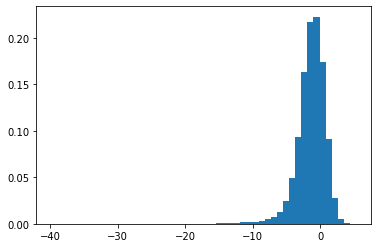

In [250]:
plt.hist(logits[-1], bins=50, density=True);

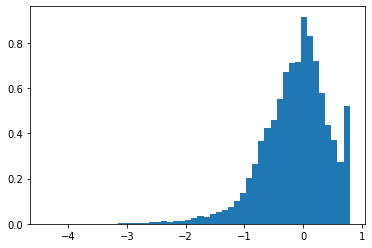

In [246]:
plt.hist(logits_clip[0], bins=50, density=True);

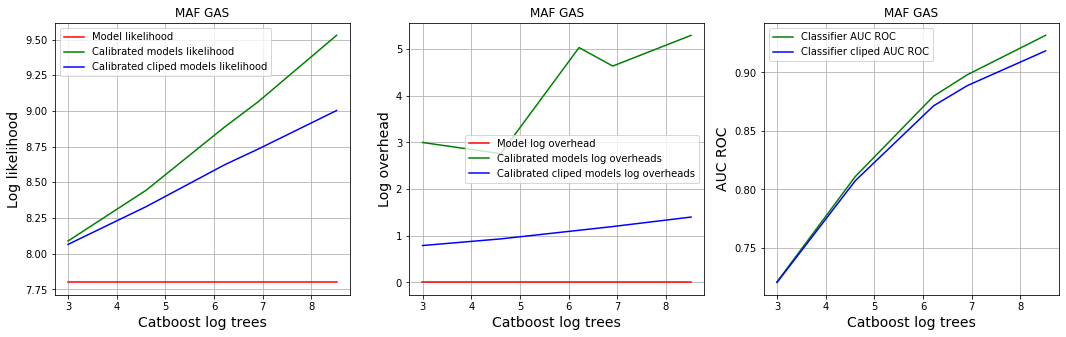

In [247]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(np.log(np.array([20, 5000])), [nll, nll], label='Model likelihood', color='red')
axs[0].plot(iters, calibrated_nlls, label='Calibrated models likelihood', color='green')
axs[0].plot(iters, calibrated_nlls_clip, label='Calibrated cliped models likelihood', color='blue')
axs[0].set_xlabel('Catboost log trees', fontsize=14)
axs[0].set_ylabel('Log likelihood', fontsize=14)
axs[0].legend()
axs[0].grid()
axs[0].set_title('MAF GAS');


overheads = [max(x) for x in logits]
overheads_cliped = [max(x) for x in logits_clip]
axs[1].plot(np.log(np.array([20, 5000])), [0, 0], label='Model log overhead', color='red')
axs[1].plot(iters, overheads, label='Calibrated models log overheads', color='green')
axs[1].plot(iters, overheads_cliped, label='Calibrated cliped models log overheads', color='blue')
axs[1].set_xlabel('Catboost log trees', fontsize=14)
axs[1].set_ylabel('Log overhead', fontsize=14)
axs[1].legend()
axs[1].grid()
axs[1].set_title('MAF GAS');

axs[2].plot(iters, auc_rocs, label='Classifier AUC ROC', color='green')
axs[2].plot(iters, auc_rocs_clip, label='Classifier cliped AUC ROC', color='blue')
axs[2].set_xlabel('Catboost log trees', fontsize=14)
axs[2].set_ylabel('AUC ROC', fontsize=14)
axs[2].legend()
axs[2].grid()
axs[2].set_title('MAF GAS');

## NN clf

In [150]:
clf_ds_train = np.row_stack([
    np.column_stack([X_train_tensor[:n].cpu().detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample_n(n).cpu().detach().numpy(), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

clf_ds_test = np.row_stack([
    np.column_stack([X_test_tensor[:n].cpu().detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample_n(n).cpu().detach().numpy(), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

clf_X_train = torch.from_numpy(clf_ds_train[:, :-1]).to(device)
clf_Y_train = torch.from_numpy(clf_ds_train[:, -1]).to(device)
clf_X_test = torch.from_numpy(clf_ds_test[:, :-1]).to(device)
clf_Y_test = torch.from_numpy(clf_ds_test[:, -1]).to(device)

In [216]:
class Densnet(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dims):
        super().__init__()
        self.layers = []
        x = in_dim
        for dim in hidden_dims + [out_dim]:
            self.layers.append(nn.Linear(x, dim))
            x += dim

        self.layers = nn.ModuleList(self.layers)
#         self.activations = [nn.ReLU()] * len(hidden_dims))
        self.activations = [nn.ReLU()] * (len(hidden_dims) - 1)
        self.activations.append(nn.Tanh())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layers[0](x)
        for activation, layer in zip(self.layers[1:], self.activations):
            x = torch.cat([x, out], dim=1)
            out = layer(activation(x))
        return out

In [217]:
nn_clf = Densnet(dim, 1, [32] * 6).to(device)
crit = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(nn_clf.parameters(), lr=0.005)

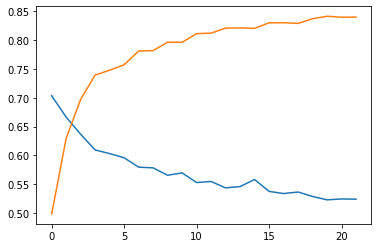

In [218]:
losses = []
nn_clfs = []

for i in range(2101):
    optim.zero_grad()
    preds = nn_clf(clf_X_train)
    loss = crit(preds.view(-1), clf_Y_train)
    loss.backward()
    optim.step()
    
    if i % 100 == 0:
        model.eval()
        with torch.no_grad():
            preds = nn_clf(clf_X_test)
            loss = crit(preds.view(-1), clf_Y_test)
            losses.append([
                loss.item(),
                roc_auc_score(clf_Y_test.detach().cpu().numpy(), preds.detach().cpu().numpy())
            ])

            clear_output(False)
            plt.plot([x[0] for x in losses], label='LogLoss')
            plt.plot([x[1] for x in losses], label='AUC ROC')
            plt.show()
    if i % 500 == 100:
        nn_clfs.append(deepcopy(nn_clf))

In [219]:
from src.nf import to_numpy, to_torch

In [220]:
class CalibratedModel:
    def __init__(self, clf, model, logit=False, c=None, n_samples_c=100):
        super().__init__()
        self.clf = self._clf_wrapper(clf)
        self.model = model
        self.logit = logit
        self.c = c or self.deduce_rejection_constant(n_samples_c)

    def log_prob(self, x):
        discr = self.clf(to_numpy(x))

        if isinstance(self.model, nn.Module):
            with torch.no_grad():
                self.model.eval()
                x = to_torch(x).to(next(self.model.parameters()).device)
                log_probs = self.model.log_prob(x).detach().cpu().numpy()
        else:
            log_probs = self.model.log_prob(x)

        if self.logit:
            return log_probs + discr
        else:
            return log_probs + np.log(discr) - np.log1p(-discr)

    def rsample(self, sample_shape=torch.Size()):
        n_samples = sample_shape.numel()
        return rejection_sampling(self, self.model, self.c, n_samples)

    def deduce_rejection_constant(self, n_samples: int, eps=0.1):
        x = to_numpy(self.model.sample_n(n_samples))
#         print(x)
        logits = self.clf(x)
        return np.max(np.exp(logits)) + eps

    @staticmethod
    def _clf_wrapper(clf):
        if isinstance(clf, CatBoostClassifier):
            return lambda x: clf.predict(x, prediction_type='RawFormulaVal')
        else:
            return clf

    def __repr__(self):
        return f'CalibratedModel(clf={self.clf}, model={self.model}, c={self.c}, logit={self.logit})'

In [233]:
nll = -neg_log_likelihood(model, X_test_tensor.cpu().detach())
print(nll)
calibrated_nlls = []
calibrated_nlls_clip = []
logits = []
logits_clip = []
auc_rocs = []
auc_rocs_clip = []

arr = []

for i, clf_ in enumerate(nn_clfs):
    samples = model.sample_n(n).cpu().detach().cpu().numpy()
    
    clf_.eval()
    with torch.no_grad():
        clf = lambda x: to_numpy(clf_(to_torch(x).to(device))).reshape(-1)

        calibrated_model = CalibratedModel(clf, model, logit=True)
        clf_preds = clf(samples)
        calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
        logits.append(clf_preds - calibration_constant)
        calibrated_nlls.append(
            -neg_log_likelihood(calibrated_model, X_test_tensor.cpu().detach()) - calibration_constant
        )
        auc_roc = roc_auc_score(
            clf_ds_test[:, -1],
            clf(clf_ds_test[:, :-1]),
        )
        auc_rocs.append(auc_roc)
        arr.append(['model', iters[i], np.max(clf_preds), auc_roc, calibration_constant, np.max(logits[-1]), calibrated_nlls[-1]])

        calibrated_model = CalibratedModel(
            lambda x: np.clip(clf(x), -100, np.log(2) + calibration_constant),
            model,
            logit=True
        )
        clf_preds = np.clip(clf(samples), -10, np.log(2) + calibration_constant)
        calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
        logits_clip.append(clf_preds - calibration_constant)
        calibrated_nlls_clip.append(
            -neg_log_likelihood(calibrated_model, X_test_tensor.cpu().detach()) - calibration_constant
        )
        auc_roc = roc_auc_score(
            clf_ds_test[:, -1],
            np.clip(clf(clf_ds_test[:, :-1]), -10, np.log(2)),
        )
        auc_rocs_clip.append(auc_roc)
        arr.append(['cliped', iters[i], np.max(clf_preds), auc_roc, calibration_constant, np.max(logits_clip[-1]), calibrated_nlls_clip[-1]])

7.798459053039551


In [234]:
pd.DataFrame(arr, columns=['model type', 'log iters', 'max clf pred', 'auc roc', 'calib const', 'max logit', 'nll'])

,model type,log iters,max clf pred,auc roc,calib const,max logit,nll
0,model,100,1.000000,0.629370,0.027714,0.972286,7.907941
1,cliped,100,0.720862,0.629278,0.019641,0.701221,7.905099
2,model,600,1.000000,0.781205,-0.131906,1.131906,8.274486
3,cliped,600,0.561241,0.778339,-0.237912,0.799153,8.169896
4,model,1100,1.000000,0.812281,-0.204550,1.204550,8.387872
5,cliped,1100,0.488597,0.808621,-0.348121,0.836718,8.222186
6,model,1600,1.000000,0.830386,-0.078294,1.078294,8.465744
7,cliped,1600,0.614853,0.819079,-0.215677,0.830530,8.283566
8,model,2100,1.000000,0.840198,-0.187727,1.187727,8.522212
9,cliped,2100,0.505420,0.833025,-0.364695,0.870115,8.282144


In [236]:
iters = np.array([100, 600, 1100, 1600, 2100])

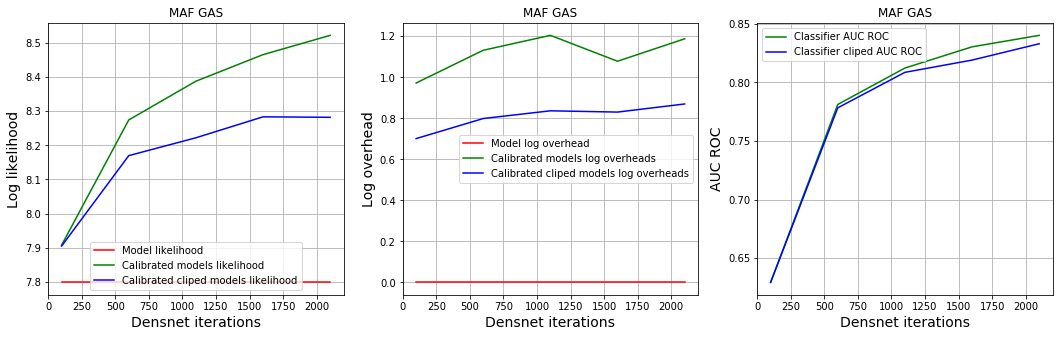

In [237]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot([iters[0], iters[-1]], [nll, nll], label='Model likelihood', color='red')
axs[0].plot(iters, calibrated_nlls, label='Calibrated models likelihood', color='green')
axs[0].plot(iters, calibrated_nlls_clip, label='Calibrated cliped models likelihood', color='blue')
axs[0].set_xlabel('Densnet iterations', fontsize=14)
axs[0].set_ylabel('Log likelihood', fontsize=14)
axs[0].legend()
axs[0].grid()
axs[0].set_title('MAF GAS');


overheads = [max(x) for x in logits]
overheads_cliped = [max(x) for x in logits_clip]
axs[1].plot([iters[0], iters[-1]], [0, 0], label='Model log overhead', color='red')
axs[1].plot(iters, overheads, label='Calibrated models log overheads', color='green')
axs[1].plot(iters, overheads_cliped, label='Calibrated cliped models log overheads', color='blue')
axs[1].set_xlabel('Densnet iterations', fontsize=14)
axs[1].set_ylabel('Log overhead', fontsize=14)
axs[1].legend()
axs[1].grid()
axs[1].set_title('MAF GAS');

axs[2].plot(iters, auc_rocs, label='Classifier AUC ROC', color='green')
axs[2].plot(iters, auc_rocs_clip, label='Classifier cliped AUC ROC', color='blue')
axs[2].set_xlabel('Densnet iterations', fontsize=14)
axs[2].set_ylabel('AUC ROC', fontsize=14)
axs[2].legend()
axs[2].grid()
axs[2].set_title('MAF GAS');

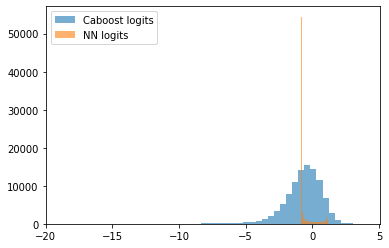

In [258]:
clf_preds = clfs[2].predict(samples, prediction_type='RawFormulaVal')
calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
gb_logist = clf_preds - calibration_constant


clf = lambda x: to_numpy(nn_clfs[-1](to_torch(x).to(device))).reshape(-1)
clf_preds = clf(samples)
calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
nn_logits = clf_preds - calibration_constant

plt.hist(gb_logist, alpha=0.6, bins=50, label='Caboost logits');
plt.hist(nn_logits, alpha=0.6, bins=50, label='NN logits');
plt.legend()

In [260]:
clf_ds_train = np.row_stack([
    np.column_stack([X_train_tensor[:n].cpu().detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample_n(n).cpu().detach().numpy(), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

clf_ds_test = np.row_stack([
    np.column_stack([X_test_tensor[:n].cpu().detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([model.sample_n(n).cpu().detach().numpy(), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

clf_X_train = torch.from_numpy(clf_ds_train[:, :-1]).to(device)
clf_Y_train = torch.from_numpy(clf_ds_train[:, -1]).to(device)
clf_X_test = torch.from_numpy(clf_ds_test[:, :-1]).to(device)
clf_Y_test = torch.from_numpy(clf_ds_test[:, -1]).to(device)

In [261]:
nn_clf = Densnet(dim, 1, [32] * 6).to(device)
crit = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(nn_clf.parameters(), lr=0.005)

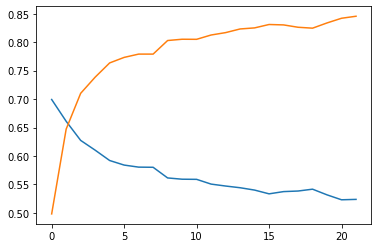

In [262]:
losses = []

for i in range(2101):
    optim.zero_grad()
    preds = nn_clf(clf_X_train)
    loss = crit(preds.view(-1), clf_Y_train)
    loss.backward()
    optim.step()
    
    if i % 100 == 0:
        model.eval()
        with torch.no_grad():
            preds = nn_clf(clf_X_test)
            loss = crit(preds.view(-1), clf_Y_test)
            losses.append([
                loss.item(),
                roc_auc_score(clf_Y_test.detach().cpu().numpy(), preds.detach().cpu().numpy())
            ])

            clear_output(False)
            plt.plot([x[0] for x in losses], label='LogLoss')
            plt.plot([x[1] for x in losses], label='AUC ROC')
            plt.show()

In [281]:
clf_cb = CatBoostClassifier(
    500,
#     eval_metric='AUC',
    loss_function='Logloss',
    metric_period=250
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

Learning rate set to 0.183105
0:	learn: 0.6880405	test: 0.6881818	best: 0.6881818 (0)	total: 18.7ms	remaining: 9.32s
250:	learn: 0.5025220	test: 0.5114963	best: 0.5114963 (250)	total: 3.61s	remaining: 3.58s
499:	learn: 0.4421216	test: 0.4588919	best: 0.4588919 (499)	total: 7.2s	remaining: 0us

bestTest = 0.4588919074
bestIteration = 499



In [272]:
len(gb_logits), len(nn_logits)

(100000, 100000)

Text(0.5, 1.0, 'Densnet logits')

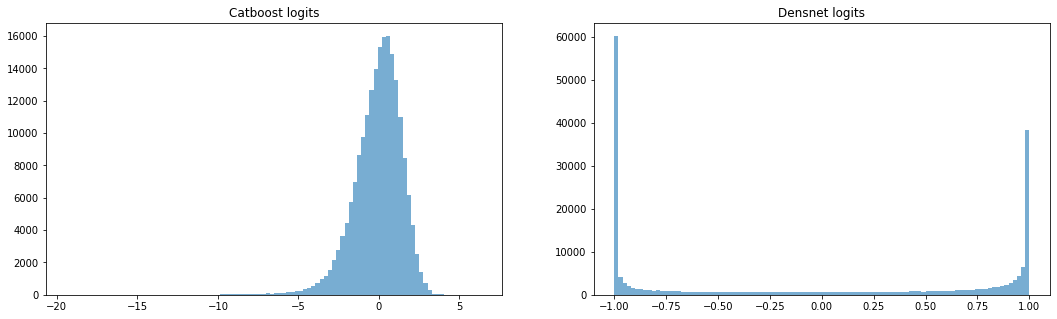

In [280]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

gb_logits = clf_cb.predict(clf_ds_test[:, :-1], prediction_type='RawFormulaVal')

clf = lambda x: to_numpy(nn_clf(to_torch(x).to(device))).reshape(-1)
nn_logits = clf(clf_ds_test[:, :-1])

axs[0].hist(gb_logits, alpha=0.6, bins=100);
axs[0].set_title('Catboost logits')
axs[1].hist(nn_logits, alpha=0.6, bins=100);
axs[1].set_title('Densnet logits')

In [68]:
n = min(100000, X_test_tensor.shape[0])

print('Calibrated model test LL ', -neg_log_likelihood(calibrated_model, X_test_tensor.cpu().detach()) - calibration_constant)

clf_ds_train = np.row_stack([
    np.column_stack([X_train_tensor[:n].cpu().detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([calibrated_model.sample_n(n), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

clf_ds_test = np.row_stack([
    np.column_stack([X_test_tensor[:n].cpu().detach().numpy(), np.ones(n).reshape(-1, 1)]),
    np.column_stack([calibrated_model.sample_n(n), np.zeros(n).reshape(-1, 1)])
]).astype(np.float32)

Calibrated model test LL  9.08264403534402


In [71]:
preds = clf.predict_proba(clf_ds_test[:, :-1])[:, 1]
roc_auc_score(clf_ds_test[:, -1], preds)

0.6955468209